# Actor Genre Stats Classification
* Using the celebrity filmography history, we compared the type of movie genres the actor performed 
in as measurement to finding similar celebrities with the same genre history.  
* There are 15 top genre that movies are classifed in.
* A movie can be classified into multipe genres.
* For ever movie a celebrity performed in, we assign a count for each movie genre the movie was labeled.
* The total genre count is then normalized based on the total number of movies.

In [1]:
# Configure Environment 
from  dev.data.settings import * 
print("Platform: " , PLATFORM)
print("Data directory : ", os.getcwd())


Platform:  dev
Data directory :  /home/jovyan/dev/data


In [2]:
import math
import os
import os.path
from pprint import pprint
import pickle
import pandas as pd
import json
from collections import defaultdict

In [3]:
genre_map = {99: 'Documentary',
 80: 'Crime',
 18: 'Drama',
 10749: 'Romance',
 35: 'Comedy',
 53: 'Thriller/Mystery',
 9648: 'Thriller/Mystery',
 12: 'Action/Adventure',
 878: 'Science Fiction/Fantasy',
 16: 'Animation',
 10751: 'Family',
 14: 'Science Fiction/Fantasy',
 28: 'Action/Adventure',
 27: 'Horror',
 10752: 'History/War',
 36: 'History/War',
 10770: 'TV Movie',
 10402: 'Music',
 37: 'Western'}

In [4]:
genre_names = list(set(genre_map.values()))

### Load data from themoviedb.org to get the list of casting role each celebrity performed in.

In [5]:
path_to_json = "./person/themoviedb/"
json_files = [path_to_json+pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json') and os.stat(path_to_json+pos_json).st_size>0]
len(json_files)


d = len(genre_names)
genre_counts = {}
for f in json_files:
    data = json.load(open(f))
    if type(data["cast"]) == dict:
        cast = data["cast"]["cast"]
    else:
        cast = data["cast"]
    gc = defaultdict(int)
    for x in cast:
        for g in x["genre_ids"]:
            gc[g] += 1
    total = sum(gc.values())
    vec = [0] * d
    for i, val in gc.items():
        vec[genre_names.index(genre_map[i])] += val
    for i in range(len(vec)): vec[i] /= total
    genre_counts[data["_actorID"]] = {}
    genre_counts[data["_actorID"]]["vec"] = vec
    genre_counts[data["_actorID"]]["name"] = data["name"]
    

## The genre stats is then vectorized and saved as a pickle file to be loaded in Elasticsearch

In [6]:
print( " Shape : ", len(genre_counts), ',', len(genre_names))
pickle.dump( genre_counts,  open( "./models/genreStats.pkl", "wb" ) )
genre_counts = pickle.load( open( './models/genreStats.pkl', 'rb' ) )
genre_counts['1']

 Shape :  100 , 15


{'vec': [0.0,
  0.0,
  0.037037037037037035,
  0.018518518518518517,
  0.18518518518518517,
  0.0,
  0.18518518518518517,
  0.07407407407407407,
  0.037037037037037035,
  0.4074074074074074,
  0.0,
  0.018518518518518517,
  0.0,
  0.037037037037037035,
  0.0],
 'name': 'Robert Downey Jr.'}

In [7]:
# Copy models up to S3 bucket
bucket = os.popen('aws ssm get-parameter --name jupyterBucketName-' + PLATFORM + ' --with-decryption | jq -r .Parameter.Value').read()
print(bucket)
executable = 'aws s3 sync ./models/ s3://' + bucket.strip() + '/models/ '
print(executable)
myCmd = os.popen(executable).read()
print(myCmd)

bdso-celebrity-content-dev-vpc-05447d97de18e28f8

aws s3 sync ./models/ s3://bdso-celebrity-content-dev-vpc-05447d97de18e28f8/models/ 
Completed 12.7 KiB/30.5 KiB (210.3 KiB/s) with 2 file(s) remaining
upload: models/celebrityBio.json to s3://bdso-celebrity-content-dev-vpc-05447d97de18e28f8/models/celebrityBio.json
Completed 12.7 KiB/30.5 KiB (210.3 KiB/s) with 1 file(s) remaining
Completed 30.5 KiB/30.5 KiB (181.0 KiB/s) with 1 file(s) remaining
upload: models/genreStats.pkl to s3://bdso-celebrity-content-dev-vpc-05447d97de18e28f8/models/genreStats.pkl



## Test Elasticsearch to store the vertor and peform cosine similarity score.


In [ ]:
import requests
from pprint import pprint
from pprint import pprint
from datetime import datetime
from elasticsearch import Elasticsearch
import json


es= Elasticsearch([{'host':ESHOST,'port':ESPORT}])

_index='genrestats'
_doc= 'genrestats'
esIndex = 'http://'+ESHOST+':'+ESPORT+'/'+_index  
headers={"Content-Type": "application/json"}

In [ ]:
d= len( genre_counts['1']['vec'])
request_body = {
  "mappings": {
    "properties": {
      "_actorID" : {
        "type" : "keyword"
      },     
      "genre_vector": {
        "type": "dense_vector",
        "dims": d
      }

    }
  }
}

try:
    es.indices.delete(index = _index)
except:
    pass
    
es.indices.create(index = _index, body = request_body)

In [ ]:
esIndex

In [ ]:
for i, d in genre_counts.items():
    _id = str(i)
    print(_id)
    doc = {
        "_actorID" : _id,
        "genre_vector": d["vec"], 
        "celebrity" : d["name"]
        }
    print(doc)
    r = requests.put(esIndex+'/_doc/'+_id, headers= headers, data = json.dumps(doc))
    
    print (r.text)

In [ ]:
r = requests.get(esIndex+'/_doc/1')
pprint(r.text)

In [ ]:
vec = json.loads(r.text)["_source"]["genre_vector"]
q={
   "_source": {
        "includes": [ "celebrity"]
        },
  "query": {
    "script_score": {

      "query" : {
        "match_all" : {}
      },
      "script": {
        "source": "cosineSimilarity(params.query_vector, doc['genre_vector']) + 1.0", 
        "params": {
          "query_vector": vec
        }
      }
    }
  }
}

res= es.search(index=_index, body=q)

pprint(res)

# Cluster Validationusing KMeans 

In [20]:
from sklearn.cluster import DBSCAN, KMeans
import numpy as np
import matplotlib.pyplot as plt

In [39]:
genre_counts

{'96': {'vec': [0.0,
   0.015151515151515152,
   0.09090909090909091,
   0.030303030303030304,
   0.16666666666666666,
   0.045454545454545456,
   0.07575757575757576,
   0.13636363636363635,
   0.09090909090909091,
   0.24242424242424243,
   0.030303030303030304,
   0.0,
   0.045454545454545456,
   0.015151515151515152,
   0.015151515151515152],
  'name': 'Chris Pine'},
 '1': {'vec': [0.0,
   0.0,
   0.037037037037037035,
   0.018518518518518517,
   0.18518518518518517,
   0.0,
   0.18518518518518517,
   0.07407407407407407,
   0.037037037037037035,
   0.4074074074074074,
   0.0,
   0.018518518518518517,
   0.0,
   0.037037037037037035,
   0.0],
  'name': 'Robert Downey Jr.'},
 '81': {'vec': [0.0,
   0.0,
   0.06976744186046512,
   0.023255813953488372,
   0.20930232558139536,
   0.0,
   0.0,
   0.13953488372093023,
   0.13953488372093023,
   0.3488372093023256,
   0.0,
   0.0,
   0.0,
   0.046511627906976744,
   0.023255813953488372],
  'name': 'Benedict Wong'},
 '100': {'vec': [0.0,

In [14]:
X = np.array([x["vec"] for x in genre_counts.values()])

In [26]:
clust = KMeans().fit(X)
y_kmeans = KMeans.predict(X)

TypeError: predict() missing 1 required positional argument: 'X'

In [16]:
clust.labels_

array([0, 7, 7, 3, 6, 4, 5, 0, 3, 3, 2, 7, 0, 0, 0, 7, 1, 7, 1, 2, 0, 0,
       7, 3, 7, 4, 5, 0, 0, 5, 4, 4, 2, 4, 1, 1, 7, 2, 2, 2, 1, 1, 3, 5,
       1, 1, 7, 4, 3, 3, 5, 3, 0, 4, 7, 7, 3, 4, 2, 4, 0, 0, 5, 3, 5, 4,
       7, 5, 4, 3, 0, 2, 3, 0, 1, 1, 1, 0, 0, 7, 3, 0, 5, 0, 0, 1, 3, 7,
       3, 7, 4, 7, 4, 4, 2, 5, 4, 5, 4, 0], dtype=int32)

In [17]:
ids = list(genre_counts.keys())

In [18]:
for c in range(max(clust.labels_)):
    c_actors = [i for i in range(len(clust.labels_)) if clust.labels_[i] == c]
    c_ids = [ids[i] for i in c_actors]
    c_names = [genre_counts[i]["name"] for i in c_ids]
    print(c_names)
    print("\n")

['Chris Pine', 'Mark Ruffalo', 'Mark Hamill', 'Johnny Depp', 'Tom Hiddleston', 'John Boyega', 'Emma Watson', 'Will Smith', 'Chris Pratt', 'Scarlett Johansson', 'Hugh Jackman', 'Danai Gurira', 'Daisy Ridley', 'Rupert Grint', 'Jon Favreau', 'Ian McKellen', 'Simon Pegg', 'Martin Freeman', 'Karen Gillan', 'Carrie Fisher']


['Jeremy Renner', 'Channing Tatum', 'Mark Wahlberg', 'Ryan Reynolds', 'Josh Brolin', 'Dwayne Johnson', 'Bruce Willis', 'Nicolas Cage', 'Denzel Washington', 'Orlando Bloom', 'Elizabeth Olsen', 'Zoe Saldana']


['Eddie Murphy', 'Adam Sandler', 'Ben Stiller', 'Owen Wilson', 'Paul Rudd', 'Steve Carell', 'Kevin Hart', 'Cameron Diaz', 'Will Ferrell']


['Taylor Lautner', 'Brad Pitt', 'Pom Klementieff', 'Shia LaBeouf', 'Christian Bale', 'Natalie Portman', 'Kristen Stewart', 'Nicole Kidman', 'Daniel Radcliffe', 'Benedict Cumberbatch', 'Sandra Bullock', 'Reese Witherspoon', 'Julia Roberts', 'Adam Driver', 'Bradley Cooper']


['Harrison Ford', 'Matt Damon', 'Ewan McGregor', 'Kean

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
PCA = pd.DataFrame(pca_2d)


<Figure size 432x288 with 0 Axes>

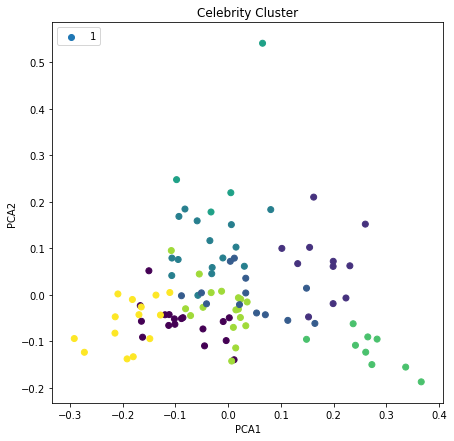

In [38]:
plt.figure('Celebrity Cluster')
plt.figure(figsize = (7,7))
plt.scatter(PCA[0], PCA[1], c=clust.labels_)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Celebrity Cluster')
plt.legend(loc='upper left')
plt.show()